## Distribution Setup

In [1]:
# from datasets import load_dataset
# from collections import defaultdict
# import random

# # Terapkan random seed untuk hasil yang dapat direproduksi
# random.seed(42)

# # Muat dataset
# dataset = load_dataset("bltlab/queryner")
# label_list = dataset['train'].features['ner_tags'].feature.names

# # --- 1. Konsolidasi Label BIO ---
# # Fungsi untuk menggabungkan label B- dan I- menjadi satu entitas
# consolidated_labels_map = {}
# consolidated_label_names = []
# for label in label_list:
#     if label.startswith('B-'):
#         entity_name = label[2:]
#         consolidated_labels_map[label] = entity_name
#         consolidated_label_names.append(entity_name)
#     elif label.startswith('I-'):
#         entity_name = label[2:]
#         consolidated_labels_map[label] = entity_name
#         consolidated_label_names.append(entity_name)
#     else: # 'O' label
#         consolidated_labels_map[label] = label
#         consolidated_label_names.append(label)
# consolidated_label_names = sorted(list(set(consolidated_label_names)))

# # Daftar label yang terpengaruh
# labels_to_plot = ['condition', 'quantity', 'price', 'origin', 'time', 'product_number']

# # Fungsi untuk menghitung entitas di split dan mengkonsolidasikan
# def count_and_consolidate(split_data):
#     counts = defaultdict(int)
#     for example in split_data:
#         for tag_id in example['ner_tags']:
#             original_label = label_list[tag_id]
#             consolidated_label = consolidated_labels_map[original_label]
#             counts[consolidated_label] += 1
#     return counts

# # Fungsi untuk menghitung data dan persentase
# def calculate_distribution(counts, labels_to_check):
#     plot_data = defaultdict(dict)
#     total_counts = {}

#     for label in labels_to_check:
#         total_counts[label] = sum(counts[split][label] for split in ['train', 'validation', 'test'])

#     for label in labels_to_check:
#         total = total_counts[label]
#         if total > 0:
#             for split in ['train', 'validation', 'test']:
#                 count = counts[split][label]
#                 percentage = (count / total) * 100 if total > 0 else 0
#                 plot_data[label][split] = {'percentage': round(percentage, 2), 'count': count}
#         else:
#             for split in ['train', 'validation', 'test']:
#                 plot_data[label][split] = {'percentage': 0, 'count': 0}

#     return plot_data

# # --- Tahap Awal: Hitung Distribusi Sebelum Penyesuaian ---
# print("Menghitung distribusi entitas sebelum penyesuaian...")
# initial_counts = {
#     'train': count_and_consolidate(dataset['train']),
#     'validation': count_and_consolidate(dataset['validation']),
#     'test': count_and_consolidate(dataset['test'])
# }
# initial_distribution = calculate_distribution(initial_counts, labels_to_plot)

# # --- Tahap Penyesuaian Distribusi Entitas ---
# print("\nMelakukan penyesuaian distribusi entitas...")
# rebalanced_dataset = {split: list(dataset[split]) for split in dataset.keys()}

# def move_samples(source_split_name, dest_split_name, label_to_move, num_to_move):
#     global rebalanced_dataset
    
#     source_split = rebalanced_dataset[source_split_name]
#     dest_split = rebalanced_dataset[dest_split_name]
    
#     potential_indices = [i for i, example in enumerate(source_split) if any(label_to_move in label_list[tag_id] for tag_id in example['ner_tags'])]
    
#     if len(potential_indices) >= num_to_move:
#         indices_to_remove = random.sample(potential_indices, num_to_move)
#     else:
#         indices_to_remove = potential_indices
    
#     if len(indices_to_remove) > 0:
#         samples_to_move = [source_split[i] for i in indices_to_remove]
#         for i in sorted(indices_to_remove, reverse=True):
#             del source_split[i]
#         dest_split.extend(samples_to_move)

# # Terapkan penyesuaian yang dijelaskan:
# move_samples('train', 'test', 'condition', 15)
# move_samples('test', 'train', 'quantity', 5)
# move_samples('train', 'validation', 'price', 3)
# move_samples('train', 'test', 'price', 2)
# move_samples('test', 'validation', 'origin', 3)
# move_samples('train', 'test', 'time', 3)
# move_samples('test', 'validation', 'product_number', 3)

# # --- Tahap Akhir: Hitung ulang distribusi setelah penyesuaian ---
# print("\nPenyesuaian selesai. Menghitung ulang distribusi entitas...")
# final_counts = {
#     'train': count_and_consolidate(rebalanced_dataset['train']),
#     'validation': count_and_consolidate(rebalanced_dataset['validation']),
#     'test': count_and_consolidate(rebalanced_dataset['test'])
# }
# final_distribution = calculate_distribution(final_counts, labels_to_plot)

In [2]:
# import os
# import json

# # Create directories if they don't exist
# os.makedirs('data/raw', exist_ok=True)
# os.makedirs('data/processed', exist_ok=True)
# os.makedirs('data/distribution', exist_ok=True)

# # Save original dataset to raw folder
# print("\nSaving original dataset...")
# for split in dataset.keys():
#     dataset[split].to_json(f'data/raw/{split}.json')
# print("Original dataset saved to data/raw/")

# # Save rebalanced dataset to processed folder
# print("\nSaving processed dataset...")
# for split, data in rebalanced_dataset.items():
#     # Convert list of examples to a format that can be saved
#     processed_data = {
#         'examples': data
#     }
#     with open(f'data/processed/{split}.json', 'w', encoding='utf-8') as f:
#         json.dump(processed_data, f, ensure_ascii=False, indent=2)
# print("Processed dataset saved to data/processed/")

# # Save distributions to distribution folder
# print("\nSaving distribution data...")
# distribution_data = {
#     'initial_distribution': initial_distribution,
#     'final_distribution': final_distribution
# }
# with open('data/distribution/label_distributions.json', 'w', encoding='utf-8') as f:
#     json.dump(distribution_data, f, ensure_ascii=False, indent=2)
# print("Distribution data saved to data/distribution/label_distributions.json")

## Data Preparation

In [5]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoConfig

In [6]:
class NERDataset(Dataset):
    def __init__(self, data_path, tokenizer, label_pad_id=-100, max_length=128):
        with open(data_path, "r", encoding="utf-8") as f:
            raw = json.load(f)["examples"]
        self.data = raw
        self.tokenizer = tokenizer
        self.label_pad_id = label_pad_id
        self.max_length = max_length

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        tokens = self.data[idx]["tokens"]
        ner_tags = self.data[idx]["ner_tags"]

        # buat encoding untuk tokens 
        encoding = self.tokenizer(
            tokens,
            is_split_into_words=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )

        # align labels dengan tokens yang sudah diencoding (jadi kepotong2 sesuai tokenization)
        word_ids = encoding.word_ids(batch_index=0)
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(self.label_pad_id)
            elif word_idx != previous_word_idx:
                aligned_labels.append(ner_tags[word_idx])
            else:
                aligned_labels.append(self.label_pad_id)
            previous_word_idx = word_idx
        
        item = {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(aligned_labels, dtype=torch.long)
        }

        return item

In [7]:
def load_label_info(model_name):
    config = AutoConfig.from_pretrained(model_name)
    id2label = config.id2label
    label2id = config.label2id
    num_labels = config.num_labels

    label_info = {
        "id2label": id2label,
        "label2id": label2id,
        "num_labels": num_labels
    }

    return label_info

def create_dataloaders(
        train_path, val_path, test_path,
        model_name,
        batch_size=32,
        max_length=128
):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_dataset = NERDataset(train_path, tokenizer, max_length=max_length)
    val_dataset = NERDataset(val_path, tokenizer, max_length=max_length)
    test_dataset = NERDataset(test_path, tokenizer, max_length=max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [8]:
train_loader, val_loader, test_loader = create_dataloaders(
    train_path=r"D:\Dafa\Project\queryner-kd\data\processed\train.json",
    val_path=r"D:\Dafa\Project\queryner-kd\data\processed\validation.json",
    test_path=r"D:\Dafa\Project\queryner-kd\data\processed\test.json",
    model_name="bert-base-uncased",
    batch_size=16,
    max_length=128
)

label_info = load_label_info("bltlab/queryner-augmented-data-bert-base-uncased")

## Model Architecture

In [9]:
from torch import nn
from torchcrf import CRF
from transformers import AutoModel, AutoConfig

In [10]:
class CRFOutputLayer(nn.Module):
    def __init__(self, hidden_dim, num_labels):
        super().__init__()
        self.fc = nn.Linear(hidden_dim, num_labels)
        self.crf = CRF(num_tags=num_labels, batch_first=True)

    def forward(self, outputs, labels=None, mask=None):
        emissions = self.fc(outputs)

        if labels is not None:
            # CRF requires first token to be valid, so we create a modified mask
            # that ensures first token is always included
            if mask is None:
                mask = torch.ones_like(labels, dtype=torch.bool)
            else:
                mask = mask.bool()
            
            # Ensure first position is always valid for CRF
            mask[:, 0] = True
            
            # Replace -100 with 0 (dummy label) to avoid index issues
            labels_crf = labels.clone()
            labels_crf[labels == -100] = 0
            
            # Calculate loss
            log_likelihood = self.crf(emissions, tags=labels_crf, mask=mask, reduction="mean")
            loss = -log_likelihood
            return {"logits": emissions, "loss": loss}
        else:
            if mask is None:
                mask = torch.ones(outputs.shape[:2], dtype=torch.bool, device=outputs.device)
            pred = self.crf.decode(emissions, mask=mask.bool())
            return {"logits": emissions, "pred": pred}


In [11]:
class BaseNERModel(nn.Module):
    def __init__(self, num_labels, use_crf=False):
        super().__init__()
        self.num_labels = num_labels
        self.use_crf = use_crf

    def forward(self, input_ids, attention_mask, labels=None):
        raise NotImplementedError("Forward method must be implemented in subclass.")

In [12]:
class QueryNERTeacher(BaseNERModel):
    def __init__(self, model_name, label_info, use_crf=False):
        super().__init__(num_labels=label_info["num_labels"], use_crf=use_crf)

        self.config = AutoConfig.from_pretrained(
            model_name,
            num_labels=label_info["num_labels"],
            id2label=label_info["id2label"],
            label2id=label_info["label2id"]
        )

        self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(0.1)

        if self.use_crf:
            self.crf_output = CRFOutputLayer(self.config.hidden_size, self.config.num_labels)
        else:
            self.classifier = nn.Linear(self.config.hidden_size, self.config.num_labels)
            self.loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    def forward(self, input_ids, attention_mask, labels=None):

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)

        if self.use_crf:
            mask = attention_mask.bool()
            result = self.crf_output(sequence_output, labels=labels, mask=mask)
            return result

        else:
            logits = self.classifier(sequence_output)
            if labels is not None:
                loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
                return {"logits": logits, "loss": loss}
            else:
                pred = logits.argmax(dim=-1)
                return {"logits": logits, "pred": pred}

In [13]:
class DistilBERTStudent(BaseNERModel):
    def __init__(self, model_name="distilbert-base-uncased", label_info=None, use_crf=False):
        self.use_crf = use_crf
        self.num_labels = label_info["num_labels"]
        super().__init__(num_labels=self.num_labels, use_crf=self.use_crf)

        self.config = AutoConfig.from_pretrained(
            model_name,
            num_labels=label_info["num_labels"],
            id2label=label_info["id2label"],
            label2id=label_info["label2id"]
        )

        self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(0.1)

        if self.use_crf:
            self.crf_output = CRFOutputLayer(self.config.hidden_size, self.num_labels)
        else:
            self.classifier = nn.Linear(self.config.hidden_size, self.num_labels)
            self.loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)

        if self.use_crf:
            mask = attention_mask.bool()
            result = self.crf_output(sequence_output, labels=labels, mask=mask)
            return result
        else:
            logits = self.classifier(sequence_output)
            if labels is not None:
                loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
                return {"logits": logits, "loss": loss}
            else:
                pred = logits.argmax(dim=-1)
                return {"logits": logits, "pred": pred}


In [14]:
class TinyBertStudent(BaseNERModel):
    def __init__(self, model_name="huawei-noah/TinyBERT_General_4L_312D", label_info=None, use_crf=False):
        self.use_crf = use_crf
        self.num_labels = label_info["num_labels"]
        super().__init__(num_labels=self.num_labels, use_crf=self.use_crf)

        self.config = AutoConfig.from_pretrained(
            model_name,
            num_labels=label_info["num_labels"],
            id2label=label_info["id2label"],
            label2id=label_info["label2id"]
        )

        self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(0.1)

        if self.use_crf:
            self.crf_output = CRFOutputLayer(self.config.hidden_size, self.num_labels)
        else:
            self.classifier = nn.Linear(self.config.hidden_size, self.num_labels)
            self.loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)

        if self.use_crf:
            mask = attention_mask.bool()
            result = self.crf_output(sequence_output, labels=labels, mask=mask)
            return result
        else:
            logits = self.classifier(sequence_output)
            if labels is not None:
                loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
                return {"logits": logits, "loss": loss}
            else:
                pred = logits.argmax(dim=-1)
                return {"logits": logits, "pred": pred}

In [15]:
class BiLSTMStudent(BaseNERModel):
    def __init__(
            self, 
            num_labels, 
            use_crf=False,
            model_name_for_vocab = 'bert-base-uncased',
            emb_dim = 300,
            lstm_hidden = 300,
            label_info = None,
            pad_token_id = 0
        ):
        super().__init__(num_labels, use_crf)
        self.use_crf = use_crf
        self.num_labels = num_labels

        config = AutoConfig.from_pretrained(model_name_for_vocab)
        vocab_size = config.vocab_size
        pad_token_id = config.pad_token_id

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_token_id)
        self.dropout = nn.Dropout(0.1)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.classifier = nn.Linear(lstm_hidden * 2, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

        if self.use_crf:
            self.crf_output = CRFOutputLayer(hidden_dim=lstm_hidden * 2, num_labels=num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        emb = self.embedding(input_ids)
        emb = self.dropout(emb)
        outputs, _ = self.lstm(emb)
        sequence_output = outputs

        if self.use_crf:
            mask = attention_mask.bool()
            result = self.crf_output(sequence_output, labels=labels, mask=mask)
            return result
        else:
            logits = self.classifier(sequence_output)
            if labels is not None:
                loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
                return {"logits": logits, "loss": loss}
            else:
                pred = logits.argmax(dim=-1)
                return {"logits": logits, "pred": pred}


In [16]:
teacher = QueryNERTeacher("bltlab/queryner-augmented-data-bert-base-uncased", label_info=label_info, use_crf=True)

Some weights of BertModel were not initialized from the model checkpoint at bltlab/queryner-augmented-data-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
student_distilbert = DistilBERTStudent(label_info=label_info, use_crf=False)

In [18]:
student_tinybert = TinyBertStudent(label_info=label_info, use_crf=False)

In [19]:
student_bilstm = BiLSTMStudent(num_labels=label_info["num_labels"], label_info=label_info, use_crf=False)

## Knowledge Distillation Scheme

In [20]:
import torch.nn.functional as F

In [21]:
# src/training/kd_trainer.py
def softmax_with_temperature(logits, temperature):
    return F.softmax(logits / temperature, dim=-1)

def kl_divergence_loss(student_logits, teacher_logits, temperature):
    p_teacher = F.log_softmax(teacher_logits / temperature, dim=-1)
    p_student = F.softmax(student_logits / temperature, dim=-1)
    loss = F.kl_div(p_teacher, p_student, reduction='batchmean')
    loss = loss * (temperature ** 2)
    return loss

def kl_divergence_loss_masked(student_logits, teacher_logits, temperature, mask=None, eps=1e-12):
    T = float(temperature)

    student_log_prob = F.log_softmax(student_logits / T, dim=-1)   # (B, L, C)
    teacher_prob = F.softmax(teacher_logits / T, dim=-1)           # (B, L, C)

    kl_elem = F.kl_div(student_log_prob, teacher_prob, reduction='none')  # (B, L, C)

    kl_token = kl_elem.sum(dim=-1)  # (B, L)

    if mask is not None:
        mask = mask.bool()
        valid_sum = mask.float().sum()
        if valid_sum.item() == 0:
            return torch.tensor(0.0, device=student_logits.device)
        kl_sum = (kl_token * mask.float()).sum()
        return (kl_sum / valid_sum) * (T * T)
    else:
        return kl_token.mean() * (T * T)

In [22]:
# src/training/kd_trainer.py
import torch
from tqdm.auto import tqdm

def _to_tensor_preds(preds, batch_size, seq_len, device):
    """
    Convert CRF decode output (list[list[int]] or list of tensors) into a tensor
    of shape (batch_size, seq_len) padded with 0s. Caller must mask invalid tokens.
    """
    pred_tensor = torch.zeros((batch_size, seq_len), dtype=torch.long, device=device)
    for i, p in enumerate(preds):
        if isinstance(p, torch.Tensor):
            p = p.tolist()
        L = len(p)
        if L > 0:
            pred_tensor[i, :L] = torch.tensor(p, dtype=torch.long, device=device)
    return pred_tensor

def _safe_get_pred_tensor(output, batch_size, seq_len, device):
    """
    Return a (batch, seq_len) tensor of predictions from model output.
    Handles:
      - output["pred"] is a tensor (batch, seq_len)
      - output["pred"] is a list of lists (per-seq predicted label ids)
      - output has no "pred" (use logits.argmax)
    """
    if "pred" in output:
        pred = output["pred"]
        if isinstance(pred, torch.Tensor):
            return pred.to(device)
        else:
            # assume list of lists
            return _to_tensor_preds(pred, batch_size, seq_len, device)
    elif "logits" in output:
        return output["logits"].argmax(dim=-1).to(device)
    else:
        raise ValueError("No 'pred' or 'logits' in model output to produce predictions.")

def _accumulate_confusion_counts(preds_flat, labels_flat):
    """
    Compute per-class TP, predicted_counts, actual_counts using vectors.
    preds_flat and labels_flat are 1D torch.Long tensors on CPU or device.
    Returns (tp_sum, pred_sum, actual_sum) and also total_tp, total_pred, total_actual per class sums.
    """
    # Assumes preds_flat and labels_flat contain non-negative ints
    if preds_flat.numel() == 0:
        return 0, 0, 0, None  # no valid tokens in this batch

    max_label = int(max(int(preds_flat.max().item()), int(labels_flat.max().item())))
    num_classes = max_label + 1

    # compute per-class counts
    tp_per_class = torch.zeros(num_classes, dtype=torch.long, device=preds_flat.device)
    pred_per_class = torch.zeros(num_classes, dtype=torch.long, device=preds_flat.device)
    actual_per_class = torch.zeros(num_classes, dtype=torch.long, device=preds_flat.device)

    for c in range(num_classes):
        pred_mask = preds_flat == c
        lab_mask = labels_flat == c
        tp_per_class[c] = int((pred_mask & lab_mask).sum().item())
        pred_per_class[c] = int(pred_mask.sum().item())
        actual_per_class[c] = int(lab_mask.sum().item())

    tp_sum = int(tp_per_class.sum().item())
    pred_sum = int(pred_per_class.sum().item())
    actual_sum = int(actual_per_class.sum().item())

    return tp_sum, pred_sum, actual_sum, (tp_per_class.cpu().numpy(), pred_per_class.cpu().numpy(), actual_per_class.cpu().numpy())

def _batch_metrics(pred_tensor, label_tensor, attention_mask):
    """
    pred_tensor: (B, L)
    label_tensor: (B, L) with -100 for ignored positions
    attention_mask: (B, L) with 1 for valid tokens
    Returns TP, predicted_count, actual_count (ints)
    """
    mask = attention_mask.bool()
    # also ensure labels not equal to -100 in valid positions
    valid = mask & (label_tensor != -100)
    if valid.sum().item() == 0:
        return 0, 0, 0

    preds_flat = pred_tensor[valid].view(-1)
    labels_flat = label_tensor[valid].view(-1)

    tp_sum, pred_sum, actual_sum, _ = _accumulate_confusion_counts(preds_flat, labels_flat)
    return tp_sum, pred_sum, actual_sum

def _final_metrics(tp_sum, pred_sum, actual_sum):
    """
    Compute micro precision, recall, f1 from aggregated counts.
    """
    precision = tp_sum / pred_sum if pred_sum > 0 else 0.0
    recall = tp_sum / actual_sum if actual_sum > 0 else 0.0
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0.0
    return precision, recall, f1

class KDTrainer:
    def __init__(
        self,
        teacher_model,
        student_model,
        train_loader,
        val_loader,
        optimizer,
        scheduler=None,
        device="cuda",
        alpha=0.5,
        beta=0.5,
        temperature=2.0
    ):
        self.teacher = teacher_model.to(device)
        self.student = student_model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.alpha = alpha
        self.beta = beta
        self.T = temperature

        for p in self.teacher.parameters():
            p.requires_grad = False

    def compute_losses(self, batch):
        input_ids = batch["input_ids"].to(self.device)
        attention_mask = batch["attention_mask"].to(self.device)  # (B, L)
        labels = batch["labels"].to(self.device)

        batch_size, seq_len = input_ids.shape

        teacher_logits = None
        if (self.alpha > 0) and (self.teacher is not None):
            with torch.no_grad():
                self.teacher.eval()
                teacher_out = self.teacher(input_ids=input_ids, attention_mask=attention_mask)
                teacher_logits = teacher_out["logits"]

        student_out = self.student(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        student_logits = student_out["logits"]

        if teacher_logits is not None:
            loss_kd = kl_divergence_loss_masked(student_logits, teacher_logits, self.T, mask=attention_mask)
            # loss_kd = kl_divergence_loss(student_logits, teacher_logits, self.T)
        else:
            loss_kd = torch.tensor(0.0, device=self.device)

        loss_student = student_out["loss"] if "loss" in student_out else torch.tensor(0.0, device=self.device)

        loss_total = self.alpha * loss_kd + self.beta * loss_student

        pred_tensor = _safe_get_pred_tensor(student_out, batch_size, seq_len, self.device)

        return loss_total, loss_kd, loss_student, pred_tensor, labels, attention_mask

    def train_epoch(self):
        self.student.train()
        total_loss, total_kd, total_stu = 0.0, 0.0, 0.0

        tp_acc, pred_acc, actual_acc = 0, 0, 0

        for batch in tqdm(self.train_loader, desc="Training"):
            self.optimizer.zero_grad()
            loss_total, loss_kd, loss_student, pred_tensor, labels, attention_mask = self.compute_losses(batch)
            loss_total.backward()
            self.optimizer.step()

            total_loss += float(loss_total.item())
            total_kd += float(loss_kd.item())
            total_stu += float(loss_student.item()) if isinstance(loss_student, torch.Tensor) else float(loss_student)

            tp, pred_count, actual_count = _batch_metrics(pred_tensor, labels, attention_mask)
            tp_acc += tp
            pred_acc += pred_count
            actual_acc += actual_count

        avg_loss = total_loss / len(self.train_loader)
        avg_kd = total_kd / len(self.train_loader)
        avg_stu = total_stu / len(self.train_loader)

        if self.scheduler:
            self.scheduler.step(avg_loss)

        precision, recall, f1 = _final_metrics(tp_acc, pred_acc, actual_acc)
        return avg_loss, avg_kd, avg_stu, precision, recall, f1

    def validate(self):
        self.student.eval()
        total_loss, total_kd, total_stu = 0.0, 0.0, 0.0

        tp_acc, pred_acc, actual_acc = 0, 0, 0

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation"):
                loss_total, loss_kd, loss_student, pred_tensor, labels, attention_mask = self.compute_losses(batch)
                total_loss += float(loss_total.item())
                total_kd += float(loss_kd.item())
                total_stu += float(loss_student.item()) if isinstance(loss_student, torch.Tensor) else float(loss_student)

                tp, pred_count, actual_count = _batch_metrics(pred_tensor, labels, attention_mask)
                tp_acc += tp
                pred_acc += pred_count
                actual_acc += actual_count

        avg_loss = total_loss / len(self.val_loader)
        avg_kd = total_kd / len(self.val_loader)
        avg_stu = total_stu / len(self.val_loader)

        precision, recall, f1 = _final_metrics(tp_acc, pred_acc, actual_acc)
        return avg_loss, avg_kd, avg_stu, precision, recall, f1

    def train(self, num_epochs):
        history = {
            "train_loss": [], "val_loss": [],
            "train_kd": [], "val_kd": [],
            "train_stu": [], "val_stu": [],
            "train_precision": [], "train_recall": [], "train_f1": [],
            "val_precision": [], "val_recall": [], "val_f1": []
        }

        for epoch in range(1, num_epochs + 1):
            print(f"\n===== EPOCH {epoch} =====")
            train_loss, train_kd, train_stu, train_prec, train_rec, train_f1 = self.train_epoch()
            val_loss, val_kd, val_stu, val_prec, val_rec, val_f1 = self.validate()

            print(
                f"Train: total={train_loss:.4f}, KD={train_kd:.4f}, S={train_stu:.4f} | "
                f"Val: total={val_loss:.4f}, KD={val_kd:.4f}, S={val_stu:.4f}"
            )
            print(
                f"Metrics -> Train: P={train_prec:.4f}, R={train_rec:.4f}, F1={train_f1:.4f} | "
                f"Val: P={val_prec:.4f}, R={val_rec:.4f}, F1={val_f1:.4f}"
            )

            history["train_loss"].append(train_loss)
            history["train_kd"].append(train_kd)
            history["train_stu"].append(train_stu)
            history["val_loss"].append(val_loss)
            history["val_kd"].append(val_kd)
            history["val_stu"].append(val_stu)

            history["train_precision"].append(train_prec)
            history["train_recall"].append(train_rec)
            history["train_f1"].append(train_f1)
            history["val_precision"].append(val_prec)
            history["val_recall"].append(val_rec)
            history["val_f1"].append(val_f1)

        return history

In [ ]:
import torch.optim as optim

optimizer = optim.AdamW(teacher.parameters(), lr=2e-5)

trainer = KDTrainer(
    teacher_model=None,
    student_model=teacher,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    alpha=0,
    beta=1,
    temperature=2.0
)

In [24]:
history = trainer.train(num_epochs=10)


===== EPOCH 1 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

c:\Users\user\anaconda3\envs\gnn\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=0.8143, KD=0.1895, S=2.2721 | Val: total=0.6970, KD=0.2251, S=1.7982
Metrics -> Train: P=0.4574, R=0.4574, F1=0.4574 | Val: P=0.5784, R=0.5784, F1=0.5784

===== EPOCH 2 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=0.6984, KD=0.2226, S=1.8085 | Val: total=0.6540, KD=0.2470, S=1.6034
Metrics -> Train: P=0.5895, R=0.5895, F1=0.5895 | Val: P=0.6329, R=0.6329, F1=0.6329

===== EPOCH 3 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=0.6587, KD=0.2313, S=1.6560 | Val: total=0.6340, KD=0.2500, S=1.5301
Metrics -> Train: P=0.6315, R=0.6315, F1=0.6315 | Val: P=0.6488, R=0.6488, F1=0.6488

===== EPOCH 4 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=0.6295, KD=0.2360, S=1.5479 | Val: total=0.6208, KD=0.2560, S=1.4719
Metrics -> Train: P=0.6674, R=0.6674, F1=0.6674 | Val: P=0.6694, R=0.6694, F1=0.6694

===== EPOCH 5 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=0.6040, KD=0.2396, S=1.4543 | Val: total=0.6122, KD=0.2578, S=1.4392
Metrics -> Train: P=0.6924, R=0.6924, F1=0.6924 | Val: P=0.6748, R=0.6748, F1=0.6748

===== EPOCH 6 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=0.5837, KD=0.2428, S=1.3791 | Val: total=0.6062, KD=0.2570, S=1.4210
Metrics -> Train: P=0.7191, R=0.7191, F1=0.7191 | Val: P=0.6846, R=0.6846, F1=0.6846

===== EPOCH 7 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=0.5633, KD=0.2448, S=1.3065 | Val: total=0.6050, KD=0.2691, S=1.3887
Metrics -> Train: P=0.7440, R=0.7440, F1=0.7440 | Val: P=0.6891, R=0.6891, F1=0.6891

===== EPOCH 8 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=0.5458, KD=0.2471, S=1.2428 | Val: total=0.6092, KD=0.2734, S=1.3925
Metrics -> Train: P=0.7642, R=0.7642, F1=0.7642 | Val: P=0.6878, R=0.6878, F1=0.6878

===== EPOCH 9 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=0.5313, KD=0.2487, S=1.1907 | Val: total=0.6118, KD=0.2733, S=1.4016
Metrics -> Train: P=0.7832, R=0.7832, F1=0.7832 | Val: P=0.6888, R=0.6888, F1=0.6888

===== EPOCH 10 =====


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

Train: total=0.5184, KD=0.2498, S=1.1450 | Val: total=0.6115, KD=0.2722, S=1.4034
Metrics -> Train: P=0.7964, R=0.7964, F1=0.7964 | Val: P=0.6869, R=0.6869, F1=0.6869


## Empty Cache, Save History, and Plotting

In [19]:
# clear GPU memory
# torch.cuda.empty_cache()

In [25]:
json_file_name = "results/trial/Tqueryner-crf-Stiny-lr2e-5"
img_folder_path = "results/trial/img/tcrf-stiny-lr2e-5/"

In [26]:
import json
#  save history to json
with open(f"{json_file_name}.json", "w") as f:
    json.dump(history, f, indent=4)

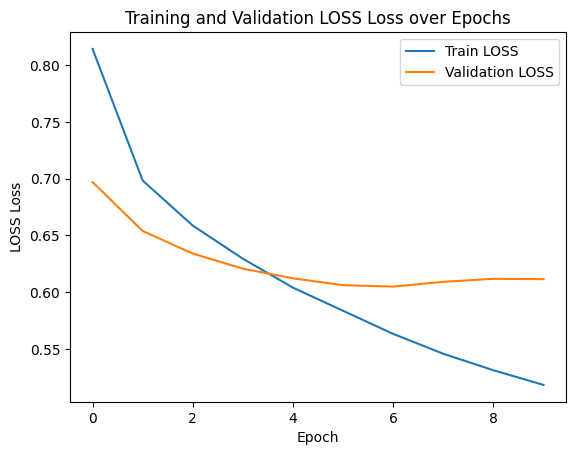

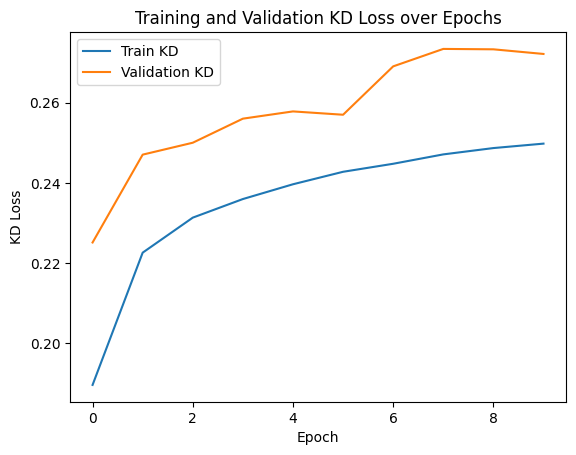

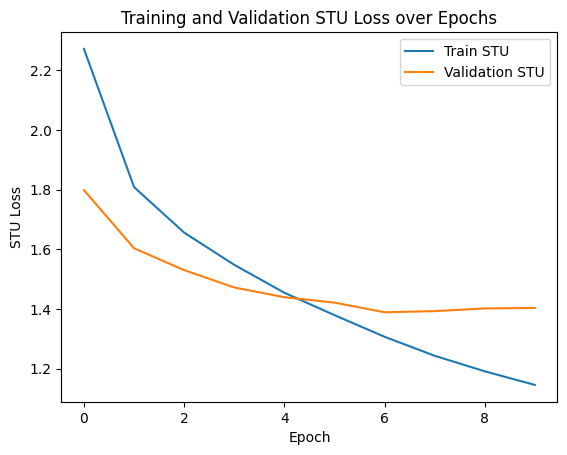

In [27]:
import matplotlib.pyplot as plt
import os

os.makedirs(img_folder_path, exist_ok=True)

list_to_plot = ["loss", "kd", "stu"]
for item in list_to_plot:
    plt.plot(history[f"train_{item}"], label=f"Train {item.upper()}")
    plt.plot(history[f"val_{item}"], label=f"Validation {item.upper()}")
    plt.xlabel("Epoch")
    plt.ylabel(f"{item.upper()} Loss")
    plt.legend()
    plt.title(f"Training and Validation {item.upper()} Loss over Epochs")
    plt.savefig(f"{img_folder_path}{item}.png") 
    plt.show()
    plt.close()

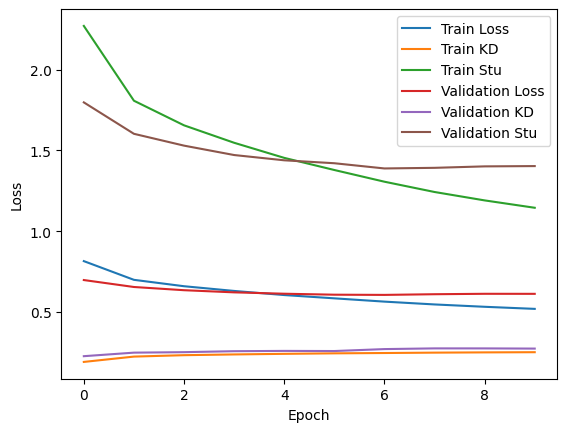

In [28]:
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["train_kd"], label="Train KD")
plt.plot(history["train_stu"], label="Train Stu")
plt.plot(history["val_loss"], label="Validation Loss")
plt.plot(history["val_kd"], label="Validation KD")
plt.plot(history["val_stu"], label="Validation Stu")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"{img_folder_path}all_losses.png")
plt.show()